# GP Regression with a Spectral Mixture Kernel

## Introduction

This example shows how to use a `SpectralMixtureKernel` module on an `ExactGP` model. This module is designed for

- When you want to use exact inference (e.g. for regression)
- When you want to use a more sophisticated kernel than RBF

The Spectral Mixture (SM) kernel was invented and discussed in [Wilson et al., 2013](https://arxiv.org/pdf/1302.4245.pdf).

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In the next cell, we set up the training data for this example. We'll be using 15 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

In [2]:
train_x = torch.linspace(0, 1, 15)
train_y = torch.sin(train_x * (2 * math.pi))

## Set up the model

The model should be very similar to the `ExactGP` model in the [simple regression example](./Simple_GP_Regression.ipynb).

The only difference is here, we're using a more complex kernel (the `SpectralMixtureKernel`). This kernel requires careful initialization to work properly. To that end, in the model `__init__` function, we call

```
self.covar_module = gpytorch.kernels.SpectralMixtureKernel(n_mixtures=4)
self.covar_module.initialize_from_data(train_x, train_y)
```

This ensures that, when we perform optimization to learn kernel hyperparameters, we will be starting from a reasonable initialization.

In [5]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process.
The spectral mixture kernel's hyperparameters start from what was specified in `initialize_from_data`.

See the [simple regression example](./Simple_GP_Regression.ipynb) for more info on this step.

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 1.281
Iter 2/100 - Loss: 1.258
Iter 3/100 - Loss: 1.232
Iter 4/100 - Loss: 1.212
Iter 5/100 - Loss: 1.192
Iter 6/100 - Loss: 1.172
Iter 7/100 - Loss: 1.156
Iter 8/100 - Loss: 1.143
Iter 9/100 - Loss: 1.131
Iter 10/100 - Loss: 1.121
Iter 11/100 - Loss: 1.114
Iter 12/100 - Loss: 1.110
Iter 13/100 - Loss: 1.106
Iter 14/100 - Loss: 1.103
Iter 15/100 - Loss: 1.101
Iter 16/100 - Loss: 1.098
Iter 17/100 - Loss: 1.094
Iter 18/100 - Loss: 1.089
Iter 19/100 - Loss: 1.085
Iter 20/100 - Loss: 1.080
Iter 21/100 - Loss: 1.076
Iter 22/100 - Loss: 1.072
Iter 23/100 - Loss: 1.069
Iter 24/100 - Loss: 1.067
Iter 25/100 - Loss: 1.065
Iter 26/100 - Loss: 1.063
Iter 27/100 - Loss: 1.061
Iter 28/100 - Loss: 1.060
Iter 29/100 - Loss: 1.057
Iter 30/100 - Loss: 1.054
Iter 31/100 - Loss: 1.051
Iter 32/100 - Loss: 1.048
Iter 33/100 - Loss: 1.044
Iter 34/100 - Loss: 1.039
Iter 35/100 - Loss: 1.035
Iter 36/100 - Loss: 1.029
Iter 37/100 - Loss: 1.023
Iter 38/100 - Loss: 1.015
Iter 39/100 - Loss: 1

Now that we've learned good hyperparameters, it's time to use our model to make predictions. The spectral mixture kernel is especially good at extrapolation. To that end, we'll see how well the model extrapolates past the interval `[0, 1]`.

In the next cell, we plot the mean and confidence region of the Gaussian process model. The `confidence_region` method is a helper method that returns 2 standard deviations above and below the mean.

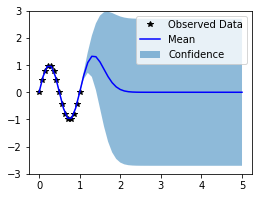

In [7]:
# Test points every 0.1 between 0 and 5
test_x = torch.linspace(0, 5, 51)

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    observed_pred = likelihood(model(test_x))

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])